# Analisi del prezzo del vino

## Progetto finale "Laboratorio di Big Data" 

### 1. Creazione Spark Session e importazione del dataset

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('FinalProject').getOrCreate()

In [3]:
df = spark.read.csv('white-wine-price-rating.csv', header=True, inferSchema=True)

In [4]:
df.columns

['FullName',
 'Winery',
 'WineName',
 'Year',
 'Region',
 'RegionalVariety',
 'VintageRating',
 'VintageRatingCount',
 'WineRating',
 'WineRatingCount',
 'VintagePrice',
 'WinePrice',
 'VintageRatingPriceRatio',
 'WineRatingPriceRatio']

Lo scopo principale dell'analisi è creare un modello predittivo per il prezzo date determinate caratteristiche. Al fine di prevedere il prezzo, dato dalla colonna WinePrice, ignorerò le variabili con l'attributo vintage, perchè come possiamo osservare di seguito, il prezzo vintage è identico al prezzo non vintage, quindi possiamo eliminare la variabile. 

In [5]:
df.select('VintagePrice','WinePrice').show(25)

+------------+---------+
|VintagePrice|WinePrice|
+------------+---------+
|      806.58|   806.58|
|       680.0|    680.0|
|       448.0|    448.0|
|     164.675|  164.675|
|     3478.36|  3478.36|
|      4022.8|   4022.8|
|      2420.0|   2420.0|
|       864.0|    864.0|
|     7249.11|  7249.11|
|     5419.19|  5419.19|
|     2923.84|  2923.84|
|     1008.22|  1008.22|
|      366.68|   366.68|
|      6800.0|   6800.0|
|      393.21|   393.21|
|      207.17|   207.17|
|       260.0|    260.0|
|       599.0|    599.0|
|       223.0|    223.0|
|       259.0|    259.0|
|       400.0|    400.0|
|       250.0|    250.0|
|       220.0|    220.0|
|       245.0|    245.0|
|       226.0|    226.0|
+------------+---------+
only showing top 25 rows



In [6]:
df.select('FullName','Winery','WineName').show()

+--------------------+--------------------+--------------------+
|            FullName|              Winery|            WineName|
+--------------------+--------------------+--------------------+
|Domaine Coche-Dur...|  Domaine Coche-Dury|Meursault Les Rou...|
|Joseph Drouhin Mo...|      Joseph Drouhin|Montrachet Grand ...|
|Marcassin Marcass...|           Marcassin|Marcassin Vineyar...|
|M. Chapoutier Erm...|       M. Chapoutier|Ermitage Le Méal ...|
|Domaine Coche-Dur...|  Domaine Coche-Dury|Corton-Charlemagn...|
|Domaine Coche-Dur...|  Domaine Coche-Dury|Corton-Charlemagn...|
|Keller G-Max Ries...|              Keller|      G-Max Riesling|
|Château Haut-Brio...|  Château Haut-Brion|Pessac-Léognan Bl...|
|Domaine de La Rom...|Domaine de La Rom...|Montrachet Grand Cru|
|Domaine de La Rom...|Domaine de La Rom...|Montrachet Grand Cru|
|Domaine Coche-Dur...|  Domaine Coche-Dury|Corton-Charlemagn...|
|Domaine Coche-Dur...|  Domaine Coche-Dury|Meursault Les Rou...|
|Olivier Leflaive ...|   

Osserviamo che la prima variabile FullName è l'unione delle variabili Winery e WineName. Eliminerò quindi la variabile FullName e terrò le altre due, tenendo in considerazione il fatto che però il WineName complichi solamente il modello in fase di encoding: vale l'assunzione per cui si presume che vi sia una sola etichetta(in termini di prodotto) per una data cantina, dato un determinato territorio e uvaggio. 

Procedo quindi prima dell'analisi esplorativa, al dropping delle colonne superflue, creando prima una copia del dataset.


In [7]:
df1 = df

In [8]:
df1 = df1.drop('FullName', 'VintageRating', 'VintageRatingCount','VintagePrice',
             'VintageRatingPriceRatio', 'WineRatingPriceRatio')

In [9]:
print((df.count(), len(df.columns)))

(4594, 14)


In [10]:
print((df1.count(), len(df1.columns)))

(4594, 8)


In [11]:
df1.columns

['Winery',
 'WineName',
 'Year',
 'Region',
 'RegionalVariety',
 'WineRating',
 'WineRatingCount',
 'WinePrice']

In [12]:
df1.printSchema()

root
 |-- Winery: string (nullable = true)
 |-- WineName: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- RegionalVariety: string (nullable = true)
 |-- WineRating: double (nullable = true)
 |-- WineRatingCount: integer (nullable = true)
 |-- WinePrice: double (nullable = true)



### 2. Analisi esplorativa

In questa fase andrò a valutare le singole variabili e a plottarle per eventualmente rimuovere eventuali outliers che possano influenzare negativamente i modelli. 

Un'aspetto molto importante da tenere in considerazione in questo caso è l'anno: non andrò a convertirlo in formato date, in quanto l'anno per un vino è una variabile che può essere considerata nominale, una caratteristica che associata al prezzo non è legata al fattore temporale, visto che possono esserci le così dette 'annate'.


In [13]:
df1.filter(df1['WineRating']<3.6).show()  

+--------+----------------+----+------+---------------+----------+---------------+---------+
|  Winery|        WineName|Year|Region|RegionalVariety|WineRating|WineRatingCount|WinePrice|
+--------+----------------+----+------+---------------+----------+---------------+---------+
|Paradies|Riesling Trocken|2017|German|       Riesling|       3.5|            177|     23.5|
+--------+----------------+----+------+---------------+----------+---------------+---------+



In [14]:
df1.filter(df1['WineRating']>4.7).show() 

+------+--------+----+------+---------------+----------+---------------+---------+
|Winery|WineName|Year|Region|RegionalVariety|WineRating|WineRatingCount|WinePrice|
+------+--------+----+------+---------------+----------+---------------+---------+
+------+--------+----+------+---------------+----------+---------------+---------+



Il valore minimo di WineRating è 3.5, mentre il massimo è 4.7.

Per il plotting, si deve necessariamente creare una copia del dataframe pyspark in pandas dataframe,con la funzione toPandas(), perchè Spark è sprovvisto di librerie dedicate.

In [15]:
df_plot = df1.toPandas()

In [16]:
df_plot

,Winery,WineName,Year,Region,RegionalVariety,WineRating,WineRatingCount,WinePrice
0,Domaine Coche-Dury,Meursault Les Rougeots,2001,Burgundy,Côte de Beaune White,4.7,755,806.580
1,Joseph Drouhin,Montrachet Grand Cru Marquis de Laguiche,2015,Burgundy,Côte de Beaune White,4.6,1191,680.000
2,Marcassin,Marcassin Vineyard Chardonnay,2013,Californian,Chardonnay,4.6,884,448.000
3,M. Chapoutier,Ermitage Le Méal Blanc,2006,Northern Rhône,White,4.5,414,164.675
4,Domaine Coche-Dury,Corton-Charlemagne Grand Cru,2007,Burgundy,Côte de Beaune White,4.7,454,3478.360
...,...,...,...,...,...,...,...,...
4589,Domaine du Tunnel,Saint-Péray Roussanne,2018,Northern Rhône,Saint-Péray,4.0,543,23.530
4590,Brown Brothers,Patricia Chardonnay,2010,Australian,Chardonnay,4.0,194,29.480
4591,Litmus Wines,White Pinot,2015,None,None,4.0,91,24.500
4592,Rollin Père et Fils,Pernand-Vergelesses 'Les Cloux',2017,Burgundy,Côte de Beaune White,4.1,330,20.160


In [17]:
import seaborn as sns

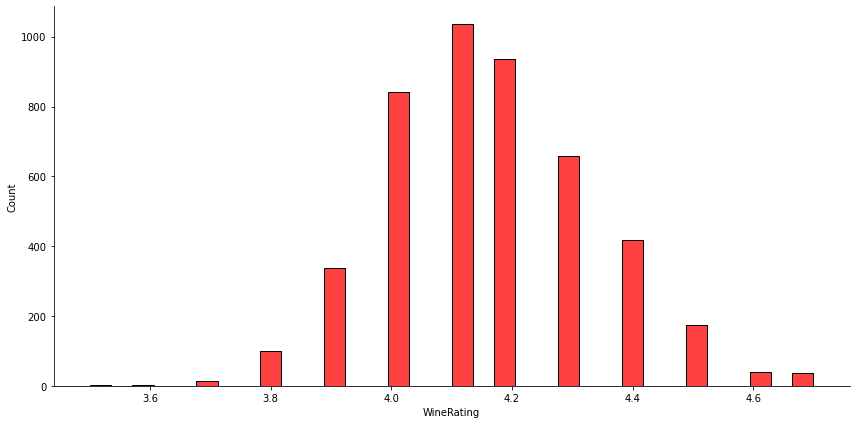

In [18]:
sns.displot(df_plot['WineRating'],aspect=2,color='red',height=6)

I rating seguono grossomodo una distribuzione normale con circa 1000 ossrevazioni con un rating di 4.1


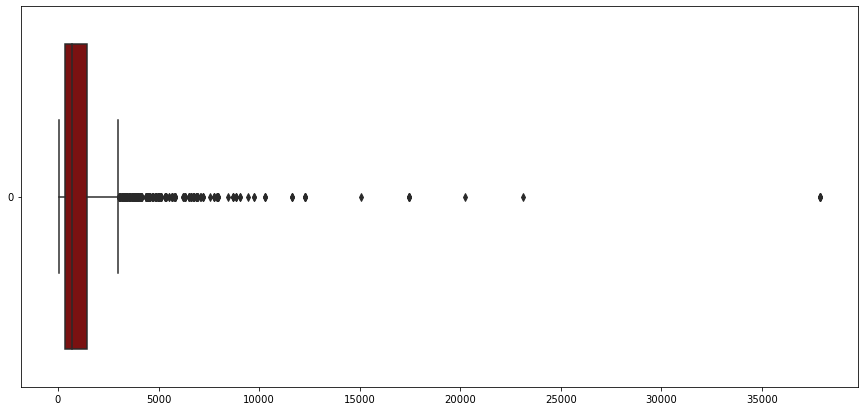

In [19]:
bp1 = sns.boxplot(data=df_plot['WineRatingCount'],color='darkred',orient='h')
bp1.figure.set_size_inches(15,7)

Nel boxplot possiamo subito vedere che siamo in presenza di alcuni outlier, in particolare le osservazioni sopra le 10000 valutazioni. Provvedo all'eliminazione di questi outlier con un drop nel dataframe Spark che userò per i modelli, ponendo una soglia di 8000. 

In [20]:
df1 = df1.filter(df1.WineRatingCount<8000)

In [21]:
df1.filter(df1['WineRatingCount']>8000).count()

0

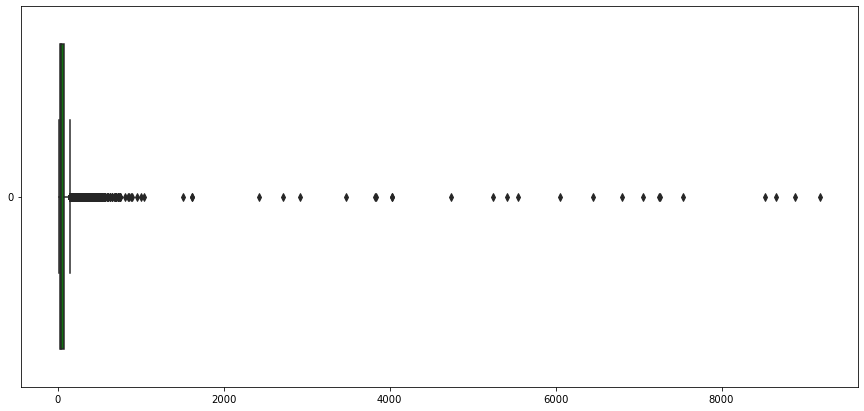

In [22]:
bp_price = sns.boxplot(data=df_plot['WinePrice'],color='green',orient='h')
bp_price.figure.set_size_inches(15,7)

Sorge lo stesso problema osservando il boxplot del prezzo, con 20 osservazioni sopra i 2000€ e 2 osservazioni isolate poco sotto i 2000. Procediamo quindi a un filtraggio eliminando tutte le righe che presentano un prezzo superiore ai 1000€.

In [23]:
df1 = df1.filter(df1.WinePrice<1000)

In [24]:
df1.filter(df1['WinePrice']>1000).count()

0

In [25]:
df1.count()

4530

A questo punto ci restano 4530 osservazioni. Dall' output del  dataframe pandas però sorge la presenza di valori nulli:

In [26]:
df2 = df1

In [27]:
df2 = df2.dropna()

In [28]:
print(df2.count(),df1.count())

4153 4530


Vediamo come dopo l'eliminazione dei valori nulli le osservazioni si riducono a 4153. 

### 3. Spark preprocessing: 

Per poter lavorare i dati in contesto Spark abbiamo la necessità di effetuare un laovro di preprocessing, in particolare andrò a indicizzare con uno StringIndexer le features categoriche, andrò poi a fare un lavoro di encoding attraverso il OneHotEncoding, per poi creare un requisito fondamentare per il training dei modelli di machine learning, il VectorAssembler. 

Tutti questi passaggi ci vengono facilitati attraverso la creazione di una Pipeline, una tecnica fondamentale in programmazione distribuita. L'output della pipeline in questo caso sarà il dataframe spark pronto con tutte le feature, che verranno filtrate successivamente con un select() per poi esser pronte al training dei modelli.

In [32]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

In [33]:
indexer = StringIndexer(inputCols=('Winery','Region','RegionalVariety','Year'), 
                        outputCols=('WineryNDX','RegionNDX','RegionalVarietyNDX','YearNDX'),handleInvalid='skip')
encoder = OneHotEncoder(inputCols=('WineryNDX','YearNDX','RegionNDX','RegionalVarietyNDX'),
                        outputCols=('WineryENC','YearENC','RegionENC','RegionalVarietyENC'))
assembler = VectorAssembler(inputCols = ['WineryENC','RegionENC','RegionalVarietyENC','YearENC',
                                         'WineRating','WineRatingCount'], outputCol='features',handleInvalid='skip')

pipeline = Pipeline(stages=[indexer, encoder, assembler]) 

In [41]:
data = pipeline.fit(df2).transform(df2)

In [42]:
data

DataFrame[Winery: string, WineName: string, Year: string, Region: string, RegionalVariety: string, WineRating: double, WineRatingCount: int, WinePrice: double, WineryNDX: double, RegionNDX: double, RegionalVarietyNDX: double, YearNDX: double, WineryENC: vector, YearENC: vector, RegionENC: vector, RegionalVarietyENC: vector, features: vector]

In [43]:
df_final = data.select('features','WinePrice')

In [44]:
df_final.show(5)

+--------------------+---------+
|            features|WinePrice|
+--------------------+---------+
|(1170,[7,1074,110...|   806.58|
|(1170,[6,1074,110...|    680.0|
|(1170,[203,1077,1...|    448.0|
|(1170,[15,1080,11...|  164.675|
|(1170,[44,1081,11...|    864.0|
+--------------------+---------+
only showing top 5 rows



In df_final ci saranno solo le features prese per il modello predittivo e il prezzo del vino da prevedere.

In [45]:
df_final.printSchema()

root
 |-- features: vector (nullable = true)
 |-- WinePrice: double (nullable = true)



In [46]:
from pyspark.sql.functions import round
df_final = df_final.select('features',round(df_final['WinePrice'],2).alias('WinePrice'))

In [47]:
df_final.select('WinePrice').show(10)

+---------+
|WinePrice|
+---------+
|   806.58|
|    680.0|
|    448.0|
|   164.68|
|    864.0|
|   366.68|
|   393.21|
|   207.17|
|    260.0|
|    599.0|
+---------+
only showing top 10 rows



Dato che stiamo trattando dei prezzi, con la funzione round arrotondo al secondo decimale tenendo invariato il tipo di dato, che resta un Double. 

Ora non mi resta che effettuare uno split in training e test set e fittare una regressione lineare.

### 4.1: Regressione Lineare 

In [63]:
training_set_ns, test_set_ns = df_final.randomSplit([0.8,0.2])

In [64]:
from pyspark.ml.regression import LinearRegression

In [65]:
regressor_ns = LinearRegression(featuresCol='features', labelCol='WinePrice', predictionCol='prediction')

In [66]:
model_lm_ns = regressor_ns.fit(training_set_ns)

In [67]:
performance_lm_ns = model_lm_ns.evaluate(test_set_ns)

In [68]:
print(f"R2 measure: {performance_lm_ns.r2}")
print(f"Mean Absolute Error: {performance_lm_ns.meanAbsoluteError}")
print(f"Root Mean Squared Error: {performance_lm_ns.rootMeanSquaredError}")

R2 measure: 0.6275555958505075
Mean Absolute Error: 38.3078673364105
Root Mean Squared Error: 64.30008450864891


R2 ci spiega quanta variabilità nei dati il modello riesce a spiegarci, con dati non scalati siamo al 62% sul test set.

In [69]:
predictions_lm_ns = model_lm_ns.transform(test_set_ns)

In [70]:
predictions_lm_ns.select('WinePrice', round('prediction',2).alias('prediction')).show(20)

+---------+----------+
|WinePrice|prediction|
+---------+----------+
|   107.95|    238.45|
|    184.0|    259.82|
|   110.98|    243.57|
|   110.28|    240.26|
|    150.0|    269.66|
|   221.81|    282.68|
|    366.0|    323.77|
|   142.68|    267.46|
|   245.95|    248.45|
|   292.68|    288.83|
|    450.0|    329.92|
|    202.8|    291.28|
|   205.85|    310.68|
|    240.0|    315.36|
|   247.85|     256.4|
|    44.45|     29.06|
|    59.17|     57.47|
|    57.13|      54.1|
|    54.17|     34.18|
|   226.84|    124.19|
+---------+----------+
only showing top 20 rows



Ora partendo da df_final applicherò lo stesso procedimento ma con un MinMax scaler sulle features.

In [71]:
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(inputCol='features', outputCol='scaledFeatures')

In [72]:
scaled = scaler.fit(df_final).transform(df_final)

In [73]:
training_set_s, test_set_s = scaled.randomSplit([0.8,0.2])

In [74]:
regressor_s = LinearRegression(featuresCol='scaledFeatures', labelCol='WinePrice', predictionCol='prediction')

In [75]:
model_lm_s = regressor_s.fit(training_set_s)

In [76]:
performance_lm_s = model_lm_s.evaluate(test_set_s)

In [77]:
print(f"R2 measure - scaled: {performance_lm_s.r2}")
print(f"Mean Absolute Error - scaled: {performance_lm_s.meanAbsoluteError}")
print(f"Root Mean Squared Error - scaled: {performance_lm_s.rootMeanSquaredError}")

R2 measure - scaled: 0.6530238542630169
Mean Absolute Error - scaled: 37.59902502704328
Root Mean Squared Error - scaled: 64.51474531350453


Possiamo osservare che nonostante l' R2 sale di qualche punto percentuale. Sia il Mean Absolute error che il RMSE sono rimasti pressochè invariati, ma con un r2 maggiore preferirei il modello con i dati scalati. Posso comunque ritenermi soddisfatto dei modelli, in quanto l' RMSE in entrambe le situazioni sta sotto la media di WinePrice, che, come possiamo vedere nella cella di seguito, è di 77,53€. Questo ci fa capire che il modello performa discretamente.

In [78]:
from pyspark.sql.functions import mean
df_final.select(mean(df_final['WinePrice'])).show()

+----------------+
|  avg(WinePrice)|
+----------------+
|77.5337779918131|
+----------------+



In [79]:
predictions_lm_s = model_lm_s.transform(test_set_s)

In [80]:
predictions_lm_s.select('WinePrice', round('prediction',2).alias('prediction')).show(20)

+---------+----------+
|WinePrice|prediction|
+---------+----------+
|     42.5|     43.51|
|   262.68|    255.08|
|    155.0|    219.62|
|   192.98|    251.75|
|   342.98|    291.92|
|   116.48|    235.85|
|    174.0|    266.59|
|    240.0|    260.11|
|   402.28|    297.67|
|   197.98|    268.04|
|    460.0|    329.71|
|    145.0|    239.35|
|   292.68|    275.85|
|    348.0|    310.04|
|    372.0|    340.86|
|    725.0|    382.79|
|   422.98|    326.34|
|    43.28|     127.1|
|    57.13|     52.94|
|    54.17|     30.73|
+---------+----------+
only showing top 20 rows



In [81]:
import matplotlib.pyplot as plt
test_target_s = test_set_s.select('WinePrice')
target_points_s = [ item.WinePrice for item in test_target_s.collect() ]
target_points_s[:10]

[42.5, 262.68, 155.0, 192.98, 342.98, 116.48, 174.0, 240.0, 402.28, 197.98]

In [82]:
pred_points = [ item.prediction for item in predictions_lm_s.collect() ]

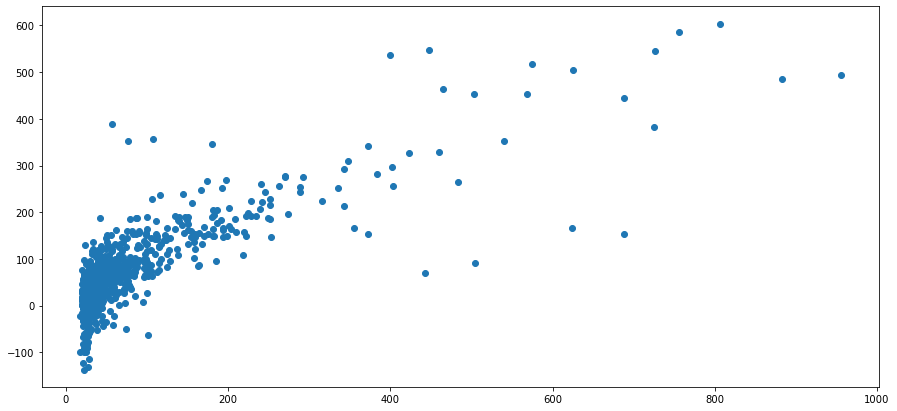

In [83]:
scatteplot_lm_s = plt.scatter(target_points_s, pred_points) 
scatteplot_lm_s.figure.set_size_inches(15,7)

Graficamente possiamo osservare che vi è un alta variabilità del modello su valori sopra i 200€. Teoricamente potremmo mettere una soglia di 200€ sui vini da dare in pasto al modello per far si che apprenda meglio e vi sia ancor meno variabilità.


### 4.2 - Random Forest

Anche in questo caso proverò a implementare una RandomForest sia per dati scalati che per dati non scalati:

In [84]:
from pyspark.ml.regression import RandomForestRegressor as RF

In [85]:
regressor_rf_ns = RF(featuresCol='features', labelCol='WinePrice', numTrees=10, maxDepth=5)

In [86]:
model_rf_ns = regressor_rf_ns.fit(training_set_ns)

In [87]:
predictions_rf_ns = model_rf_ns.transform(test_set_ns)

In [88]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="WinePrice", predictionCol="prediction", metricName="rmse")

In [90]:
rmse = evaluator.evaluate(predictions_rf_ns)

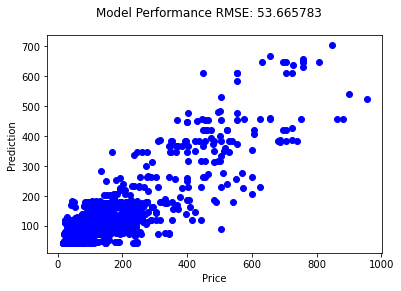

In [91]:
import matplotlib.pyplot as plt

rfPred = model_rf_ns.transform(df_final)
rfResult = rfPred.toPandas()
plt.plot(rfResult.WinePrice, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Continuiamo a osservare una certa variabilità anche con la Random Forest. In questo caso però abbiamo un RMSE di 53.25, che, rispetto al 64.30 della regressione lineare su dati non scalati, rappresenta un buon miglioramento.

In [92]:
model_rf_ns.featureImportances

SparseVector(1170, {0: 0.0315, 5: 0.0008, 7: 0.1128, 11: 0.0028, 14: 0.0162, 16: 0.0043, 19: 0.0015, 23: 0.0021, 27: 0.0003, 29: 0.0057, 37: 0.0005, 44: 0.0309, 49: 0.0014, 53: 0.0005, 63: 0.0358, 67: 0.0003, 68: 0.001, 70: 0.0006, 84: 0.0004, 100: 0.0032, 165: 0.0, 203: 0.0049, 353: 0.0082, 380: 0.0011, 436: 0.0011, 453: 0.0007, 487: 0.0008, 522: 0.0093, 699: 0.0098, 1074: 0.0079, 1076: 0.002, 1080: 0.0003, 1081: 0.0007, 1082: 0.0016, 1093: 0.0014, 1106: 0.1195, 1108: 0.0006, 1109: 0.0001, 1135: 0.0002, 1136: 0.0026, 1138: 0.0002, 1139: 0.0, 1140: 0.0026, 1141: 0.0014, 1142: 0.0027, 1144: 0.0015, 1145: 0.0001, 1146: 0.0, 1147: 0.0056, 1148: 0.0004, 1149: 0.0, 1150: 0.0062, 1151: 0.0005, 1152: 0.0001, 1166: 0.0145, 1168: 0.5025, 1169: 0.0364})

Avendo molte modalità nelle variabili categoriche, siamo di fronte a 1170 variabili, sopratutto dummies, di difficile interpretazione. Una possibile soluzione per valutare quali sono quelle che influiscono sul prezzo e fare un sorting dei valori interni al dizionario dello Sparse Vector.

In [93]:
sorted(model_rf_ns.featureImportances.values, reverse=True)[:10]

[0.5024927725294861,
 0.11947921297520567,
 0.1128123557658164,
 0.036357479350211934,
 0.03578509807709981,
 0.031526233570012524,
 0.030948606074603813,
 0.016179986900955422,
 0.014481327578298283,
 0.009827503256259081]

Tra le prime 10 variabili, una in particolare, secondo il modello, ha una Importance dello 0.50, con un netto salto rispetto alla seconda che ha un importance dello 0.11. Come osserviamo dalla cella precedente dove viene rappresentato lo Sparse Vector, si tratta della feature 1168, che stando all'ordine del dataframe originale, corrisponde al rating del vino (WineRating).

Ora passo all'implementazione della random forest sui dati scalati per valutare le differenze:

In [94]:
regressor_rf_s = RF(featuresCol='features', labelCol='WinePrice', numTrees=10, maxDepth=5)

In [95]:
model_rf_s = regressor_rf_s.fit(training_set_s)

In [96]:
predictions_rf_s = model_rf_s.transform(test_set_s)

In [97]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator_rf_s = RegressionEvaluator(labelCol="WinePrice", predictionCol="prediction", metricName="rmse")

In [98]:
rmse_rf_s = evaluator_rf_s.evaluate(predictions_rf_s)

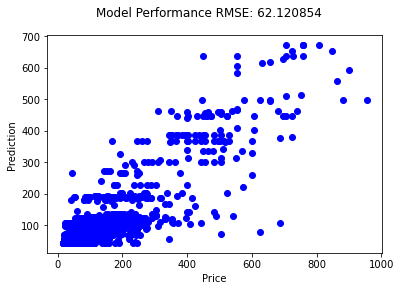

In [99]:
rfPred = model_rf_s.transform(df_final)
rfResult = rfPred.toPandas()
plt.plot(rfResult.WinePrice, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse_rf_s)
plt.show()

In questo caso l'RMSE sale a 62.12, un risultato che fa propendere verso il modello precedente.

In [100]:
model_rf_s.featureImportances

SparseVector(1170, {0: 0.0116, 1: 0.0007, 5: 0.0018, 6: 0.0012, 7: 0.1352, 11: 0.0017, 12: 0.0008, 14: 0.0017, 19: 0.0056, 21: 0.001, 29: 0.0025, 37: 0.004, 44: 0.0154, 49: 0.0007, 53: 0.001, 63: 0.0339, 64: 0.0019, 73: 0.0005, 100: 0.0035, 103: 0.003, 203: 0.0052, 343: 0.0001, 353: 0.0022, 436: 0.0022, 453: 0.0031, 487: 0.0016, 522: 0.0021, 699: 0.0077, 1074: 0.007, 1081: 0.0059, 1082: 0.0005, 1084: 0.0007, 1086: 0.0, 1105: 0.0048, 1106: 0.1004, 1135: 0.0033, 1136: 0.0007, 1137: 0.0006, 1138: 0.0001, 1139: 0.0011, 1140: 0.0, 1141: 0.0001, 1142: 0.0002, 1144: 0.0001, 1145: 0.0003, 1146: 0.0005, 1147: 0.0117, 1148: 0.0008, 1150: 0.0, 1156: 0.0006, 1157: 0.002, 1160: 0.0, 1164: 0.0011, 1168: 0.5709, 1169: 0.0346})

In [101]:
sorted(model_rf_s.featureImportances.values, reverse=True)[:10]

[0.5709339474336612,
 0.1351856085883926,
 0.10043866825044864,
 0.03459328484476911,
 0.033874962962710815,
 0.015412544519351076,
 0.011676428942378175,
 0.011580718534033335,
 0.007709826852699655,
 0.007020003403294485]

In questo caso la feature 1168 (WinePrice) ha una feature importance che sale a 0.57, mentre sale a 0.13 la feature numero 7, che plausibilmente è frutto dell'encoding nell'OneHotEncoder, perciò di difficile interpretazione.